<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_73).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**


1. [Importar bibliotecas](#Importar-bibliotecas)
2. [Carga de datos](#Carga-de-datos)
3. [Preparacion de los datos](#Preparacion-de-los-datos)
4. [Analisis por grupo de indicadores (Internet)](#Analisis-por-grupo-de-indicadores-(tecnologia))
  - [Preparacion de datos](#Preparacion-de-datos)
  - [Analisis Exploratorio](#Analisis-Exploratorio)
  - [Modelo VAR](#Modelo-VAR)
  - [Modelo VARMAX](#Modelo-VARMAX)
5. [Conclusiones](#Conclusiones)



**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Internet)

### Preparacion de datos

In [5]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','Internet']]

In [6]:
df_cont = df_sel.dropna()

In [7]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6132 entries, 1752 to 7883
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   6132 non-null   int64  
 1   Trimestre             6132 non-null   int64  
 2   Mes                   6132 non-null   int64  
 3   Codi_Districte        6132 non-null   int64  
 4   Nom_Districte         6132 non-null   object 
 5   Codi_Barri            6132 non-null   int64  
 6   Nom_Barri             6132 non-null   object 
 7   Compraventa_Unitario  6132 non-null   float64
 8   Internet              6132 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 479.1+ KB


In [8]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [9]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [10]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,Internet
Fecha,,,,,,,,,
2016-01-01,2016,1,1,1,Ciutat Vella,1,el Raval,2813.0,82.8
2016-02-01,2016,1,2,1,Ciutat Vella,1,el Raval,2813.0,82.8
2016-03-01,2016,1,3,1,Ciutat Vella,1,el Raval,2813.0,82.8
2016-04-01,2016,2,4,1,Ciutat Vella,1,el Raval,2948.8,82.8
2016-05-01,2016,2,5,1,Ciutat Vella,1,el Raval,2948.8,82.8


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [11]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 8]

In [12]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [13]:
df.head()

,Compraventa_Unitario,Internet
Fecha,,
2016-01-01,1511.900000,71.5
2016-02-01,1511.900000,71.5
2016-03-01,1511.900000,71.5
2016-04-01,1633.069231,71.5
2016-05-01,1633.069231,71.5


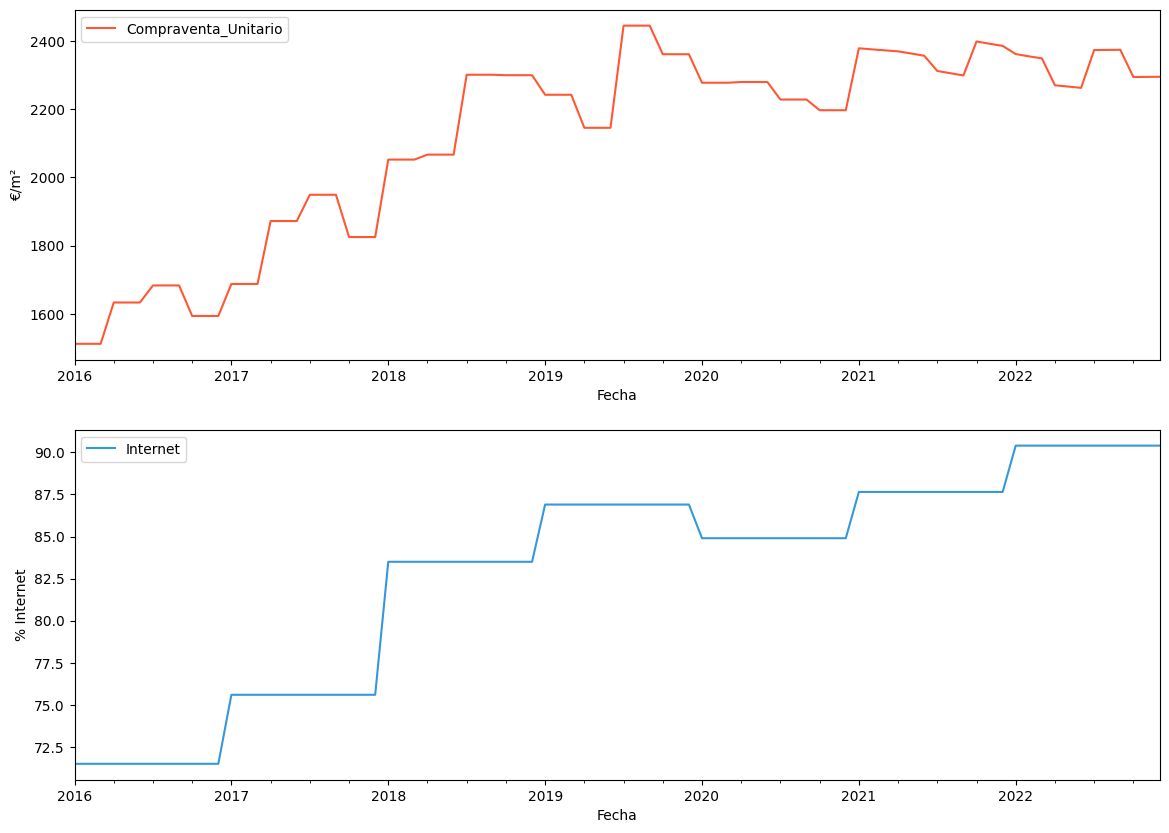

In [15]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', '% Internet']
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [16]:
corr=df.corr()
corr

,Compraventa_Unitario,Internet
Compraventa_Unitario,1.000000,0.939532
Internet,0.939532,1.000000


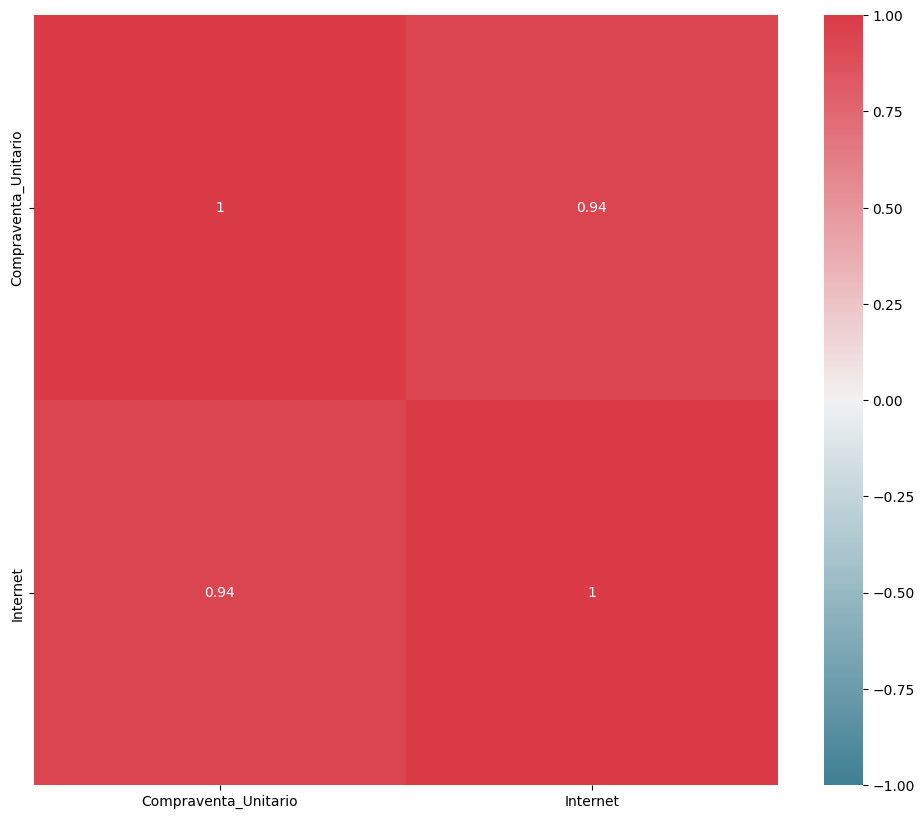

In [17]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" y "Internet" es de 0.939532, lo que sugiere una correlación muy alta entre estas dos variables en el modelo.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




##### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [18]:
fecha_division = '2022-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(72, 2) (12, 2)


##### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [19]:
import statsmodels.tsa.stattools as sts

In [20]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.394307
Serie de tiempo Internet
p-value: 0.581953


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [21]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Internet
Fecha,,
2016-02-01,0.000000,0.0
2016-03-01,0.000000,0.0
2016-04-01,121.169231,0.0
2016-05-01,0.000000,0.0
2016-06-01,0.000000,0.0


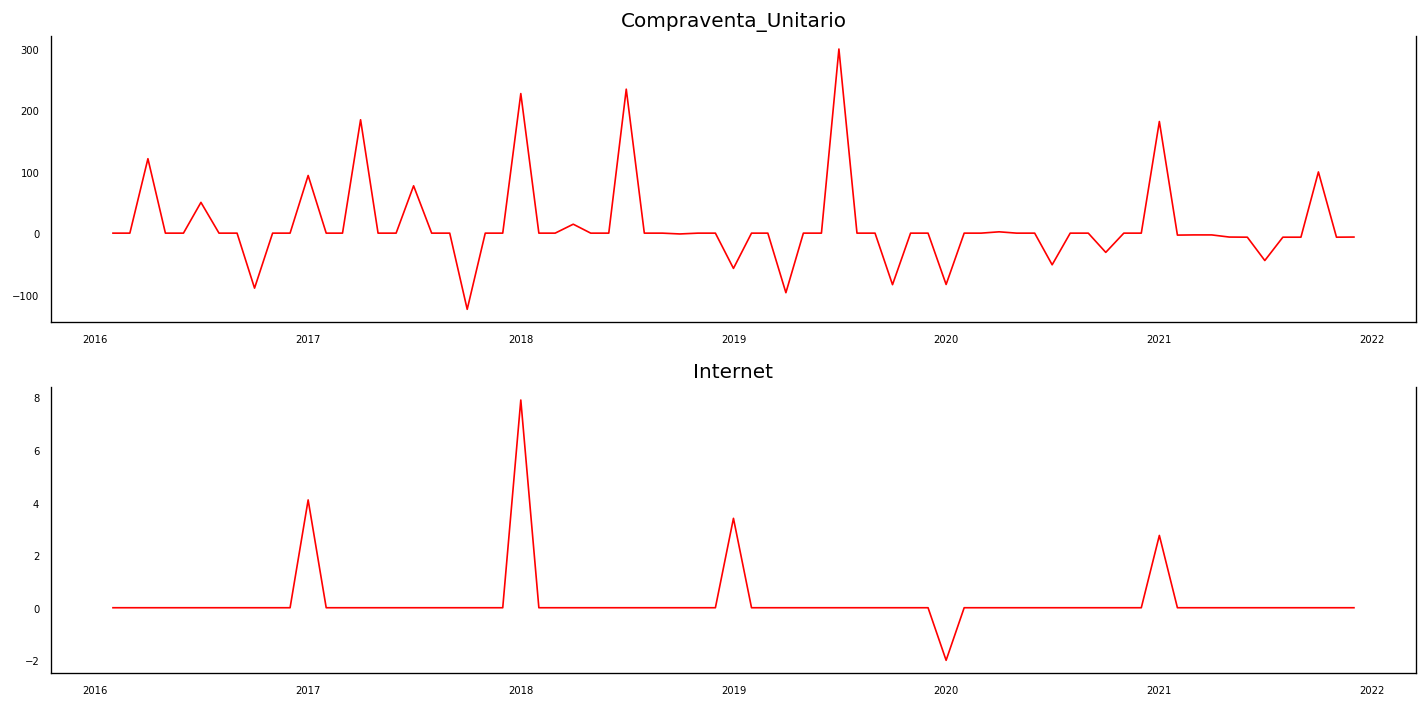

In [24]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [25]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Internet
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

In [26]:
from statsmodels.tsa.api import VAR

In [27]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

In [28]:
modelsel=model.select_order(12)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,8.820,8.890*,6767.,8.847
1,8.953,9.164,7733.,9.036
2,9.086,9.438,8838.,9.223
3,9.139,9.632,9332.,9.331
4,9.271,9.904,1.067e+04,9.518
5,9.401,10.18,1.221e+04,9.704
6,8.482,9.397,4898.,8.839*
7,8.614,9.670,5634.,9.026
8,8.745,9.942,6493.,9.212
9,8.399,9.737,4660.*,8.922


#### Ajustando el modelo

In [29]:
res = model.fit(maxlags=12, ic='aic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, May, 2024
Time:                     07:03:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.1554
Nobs:                     59.0000    HQIC:                   9.08202
Log likelihood:          -365.080    FPE:                    4957.92
AIC:                      8.39474    Det(Omega_mle):         2445.93
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            4.449694        10.180710            0.437           0.662
L1.Compraventa_Unitario         -0.000854         0.212498           -0.004           0.997
L

La correlación entre los residuos de "Compraventa_Unitario" y los residuos de "Internet" es de 0.633763, lo que sugiere una correlación moderada entre los residuos de estas dos variables en el modelo.

In [30]:
X_train.columns

Index(['Compraventa_Unitario', 'Internet'], dtype='object')

###### Causalidad de Granger

In [31]:
grangercaus=res.test_causality(['Internet'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.6949,1.897,0.751,"(12, 68)"


In [32]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['Internet'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
4.943,1.897,0.000,"(12, 68)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=12
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,Internet_x
Compraventa_Unitario_y,1.0000,0.0
Internet_y,0.0627,1.0


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

###### Diagnosis del modelo


###### Residuos

In [34]:
residuals=res.resid

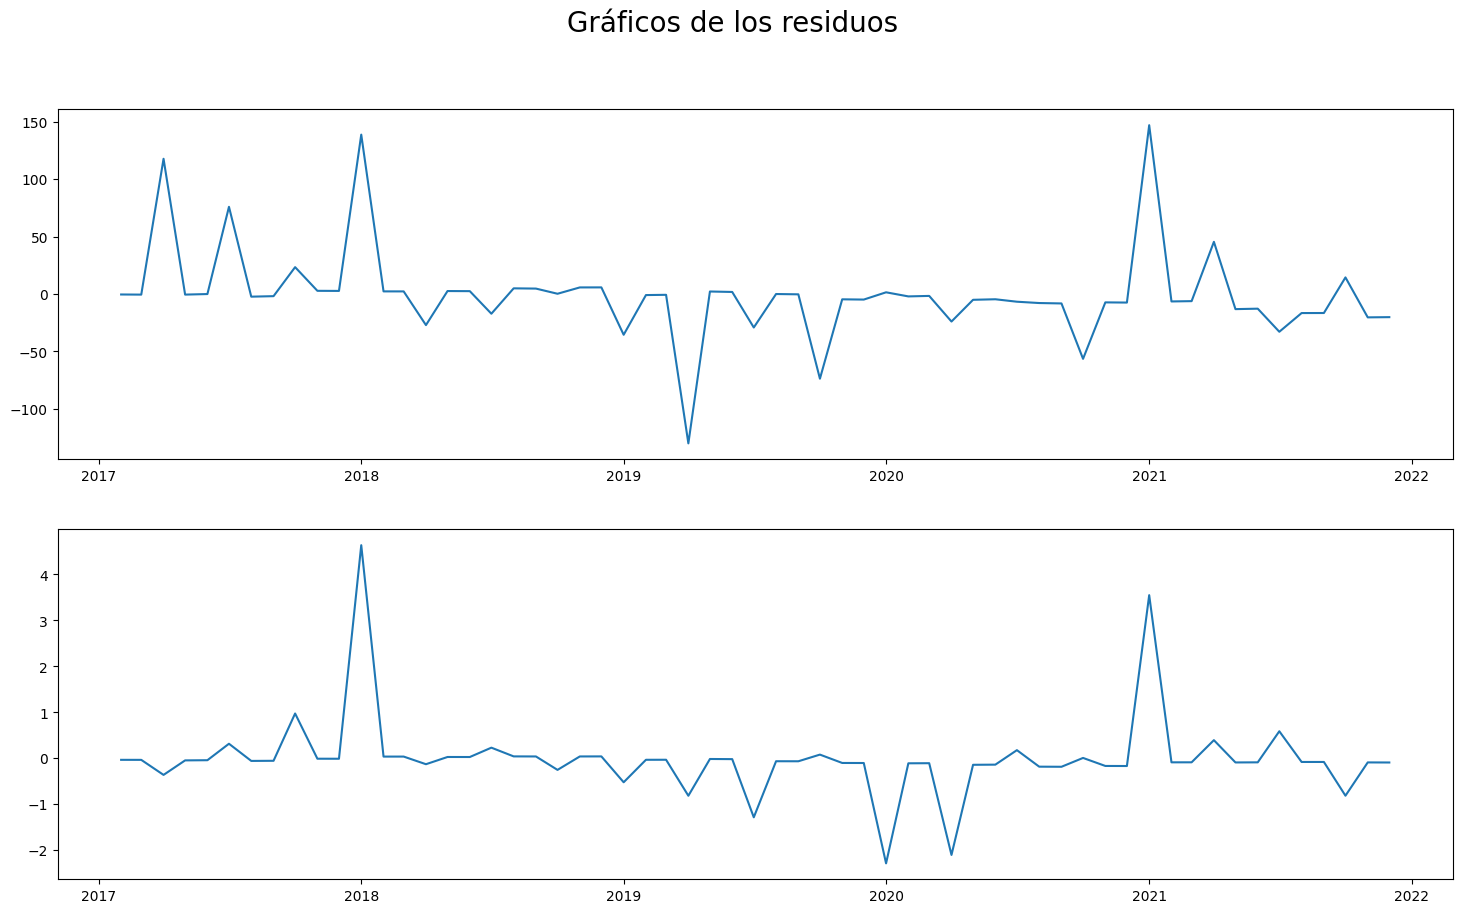

In [36]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [37]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[4.8483475132472606e-11, 6.315698006480961e-11]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 3 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


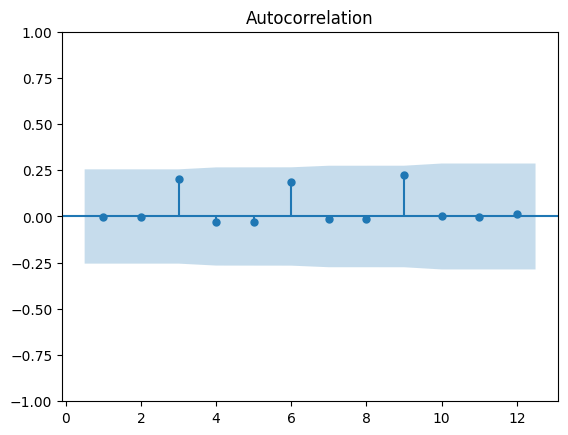

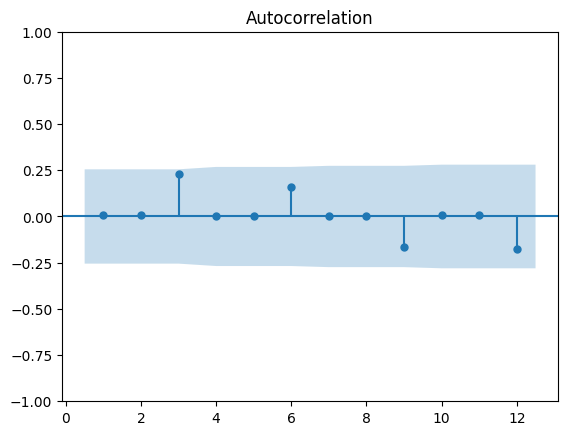

In [38]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


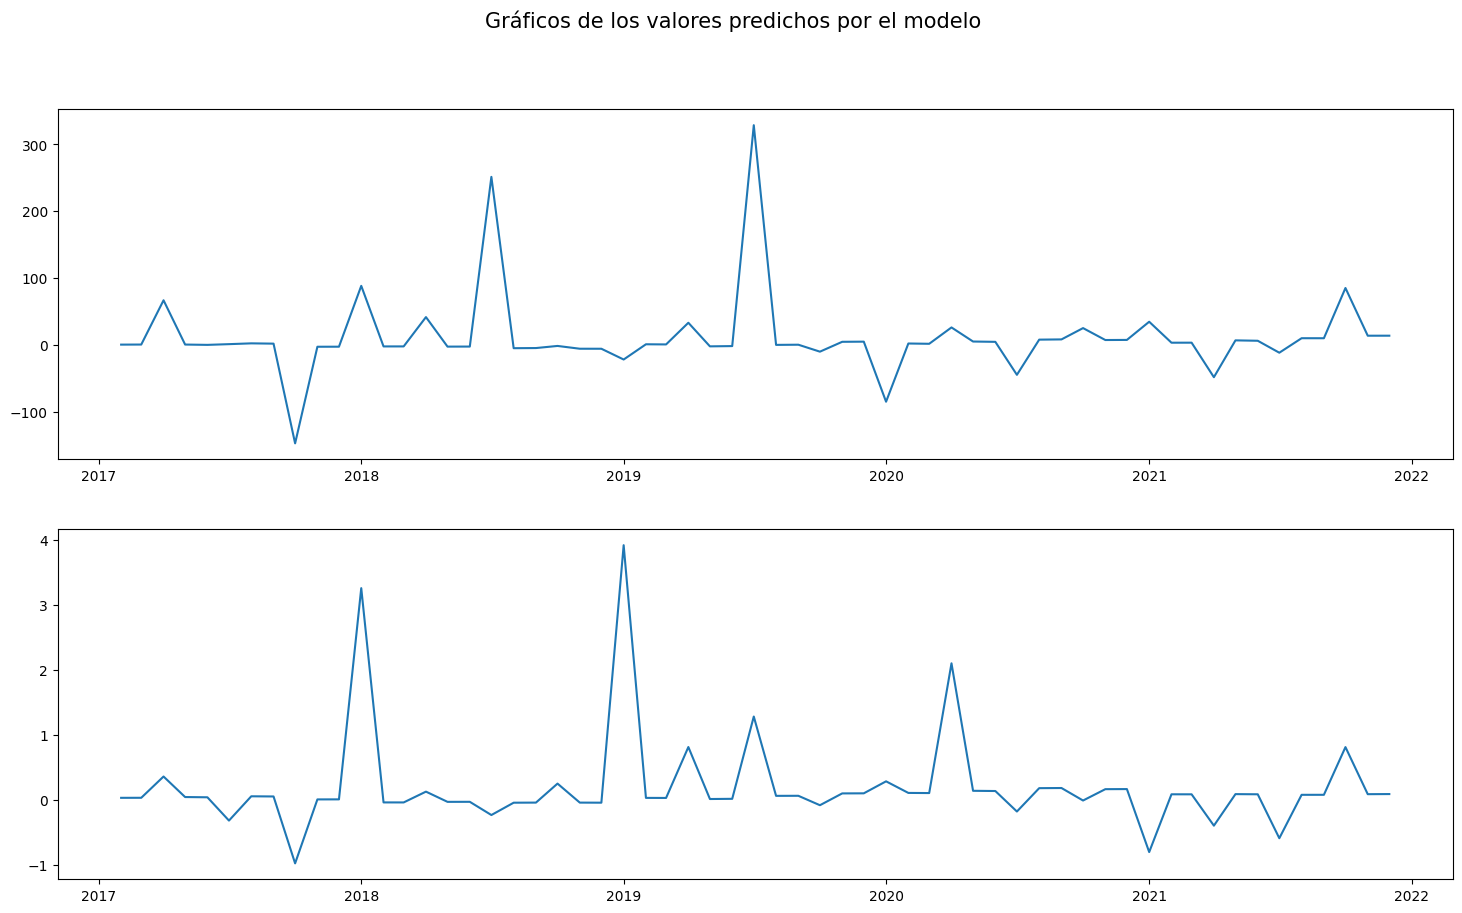

In [39]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [40]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=12)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 12
Predicciones:


,Compraventa_Unitario_pred,Internet_pred
Fecha,,
2022-01-01,30.882640,2.029944
2022-02-01,22.764349,0.144102
2022-03-01,22.302190,0.139420
2022-04-01,-75.798587,-0.906178
2022-05-01,-4.837574,0.052465
2022-06-01,-4.449401,0.053128
2022-07-01,111.294819,0.928283
2022-08-01,-6.335919,-0.064804
2022-09-01,-7.147786,-0.068589


<Figure size 1200x1000 with 0 Axes>

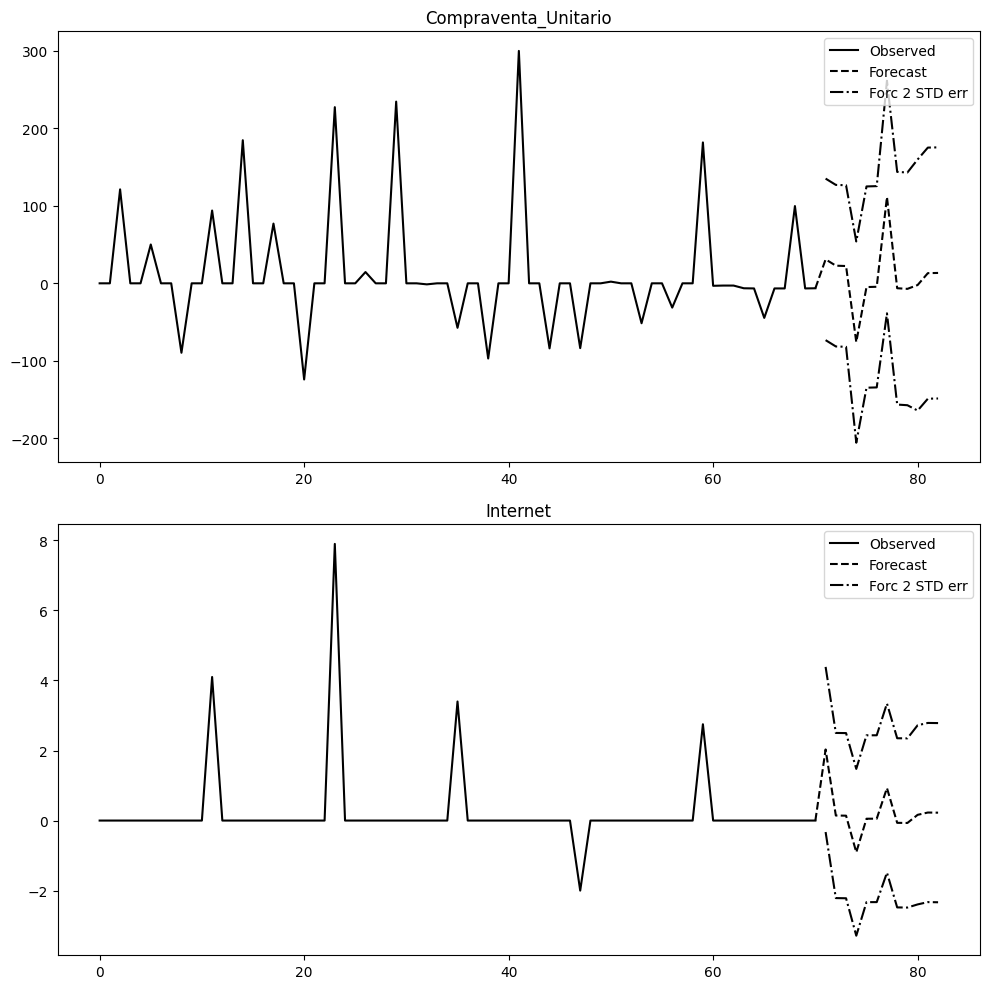

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [42]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [43]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,Internet
Fecha,,
2022-01-01,2416.626450,89.679944
2022-02-01,2439.390799,89.824045
2022-03-01,2461.692989,89.963466
2022-04-01,2385.894402,89.057288
2022-05-01,2381.056827,89.109753
2022-06-01,2376.607426,89.162880
2022-07-01,2487.902245,90.091163
2022-08-01,2481.566325,90.026359
2022-09-01,2474.418539,89.957769


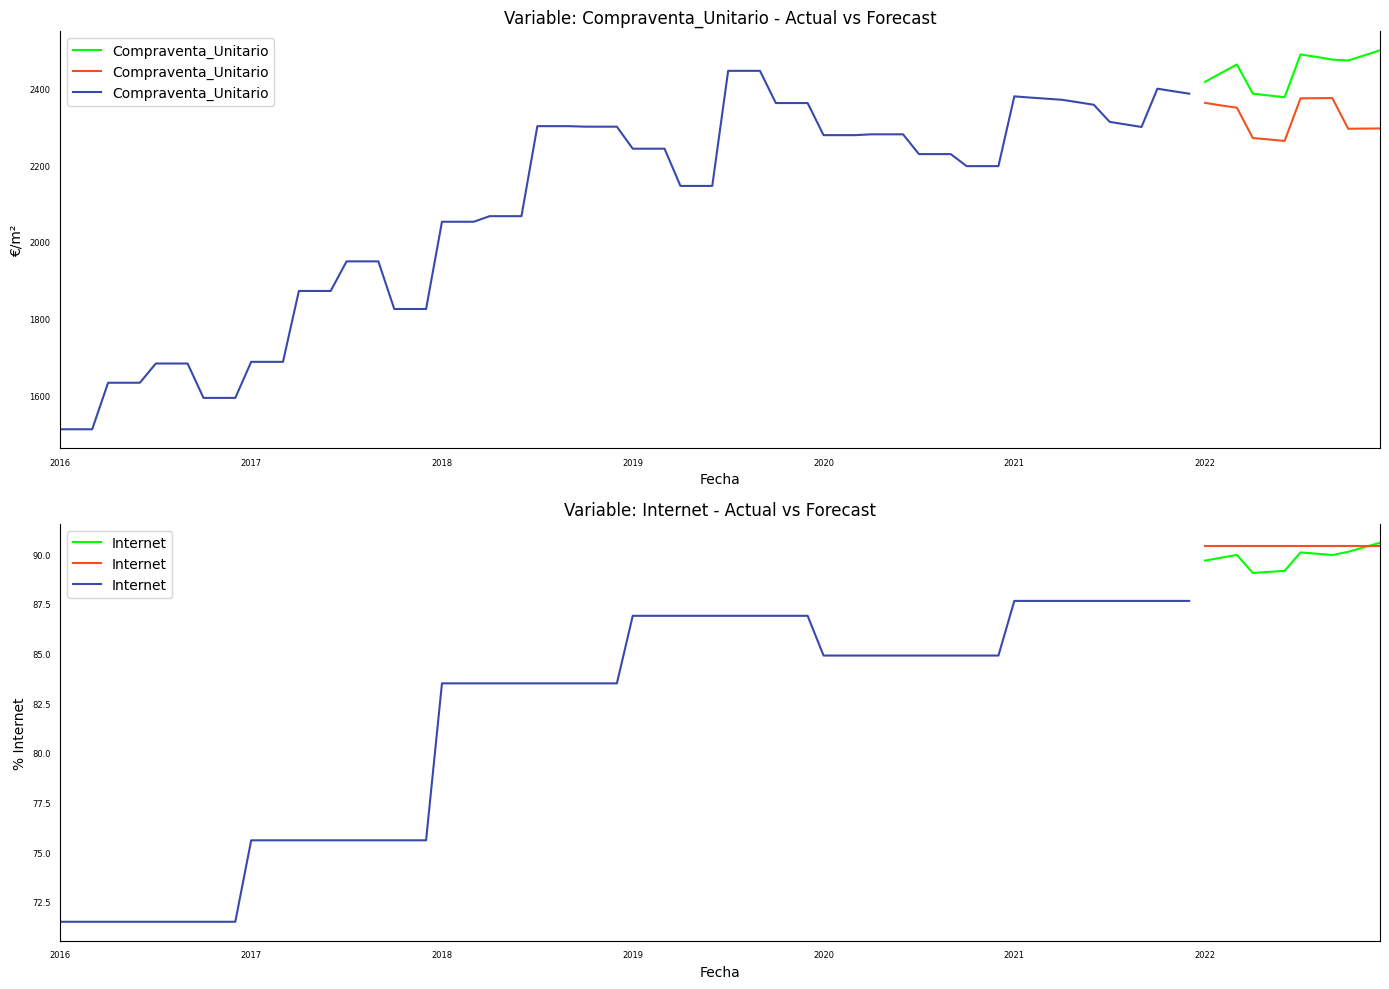

In [45]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Internet']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [46]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [47]:
for i in ['Compraventa_Unitario','Internet']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 17181.27779169077
MAE is : 124.11237231252983
RMSE is : 131.07737330176695
MAPE is : 5.362025192242912
R2 is : -7.962632566122306

Evaluation metric for Internet
Evaluation metric results:-
MSE is : 0.5483700047387272
MAE is : 0.6026035006706465
RMSE is : 0.7405200907056656
MAPE is : 0.6665967927772637
R2 is : -2.7153967408367365e+27



Estas métricas indican que el modelo para "Compraventa_Unitario" tiene un rendimiento deficiente:

- El valor negativo de R2 sugiere que el modelo no se ajusta bien a los datos.
- El MAPE y el RMSE son relativamente bajos, pero el valor negativo de R2 indica un rendimiento deficiente del modelo en la predicción de "Compraventa_Unitario".

El modelo para "Internet" muestra un rendimiento extremadamente deficiente:

- El valor extremadamente negativo de R2 indica un ajuste muy pobre del modelo a los datos.
- Las métricas de error también son altas, lo que sugiere que el modelo no puede predecir de manera efectiva la variable "Internet".

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 62.35748790660024
Root mean squared error: 92.6871786216829


### Modelo VARMAX (Auto Arima)

El modelo VARMAX es una extension del modelo VAR que permite incorporar variebles exogenas, es decir, varibales externas que pueden afectar a las series temporales del sistema, es decir, que ademas de modelar la dependencia entre las variables del sistema, el VARMAX tambien puede capturar la influencia de variables externas sobre las series temporales.

In [48]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.2 MB/s eta 0:00:00


#### Dividir los datos en conjuntos de Entrenamiento Y Prueba

In [50]:
fecha_division = '2022-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(72, 2) (12, 2)


#### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [51]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.394307
Serie de tiempo Internet
p-value: 0.581953


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [52]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Internet
Fecha,,
2016-02-01,0.000000,0.0
2016-03-01,0.000000,0.0
2016-04-01,121.169231,0.0
2016-05-01,0.000000,0.0
2016-06-01,0.000000,0.0


In [53]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Internet
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

####Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [54]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [55]:
cointegration_test(X_train_transformed[['Compraventa_Unitario', 'Internet']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  73.38     > 12.3212   =>   True
Internet >  8.44      > 4.1296    =>   True


- Para la variable "Compraventa_Unitario": El valor del estadístico de prueba es 73.38, que supera el valor crítico de 12.3212 para un nivel de significancia del 95%. Por lo tanto, se rechaza la hipótesis nula de que "Compraventa_Unitario" no causa Granger a ninguna de las otras variables incluyendo a "Internet".

- Para la variable "Internet": El valor del estadístico de prueba es 8.44, que supera el valor crítico de 4.1296 para un nivel de significancia del 95%. Por lo tanto, se rechaza la hipótesis nula de que "Internet" no causa Granger a ninguna de las otras variables incluyendo a "Compraventa_Unitario".

#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [56]:
import pmdarima as pm

In [57]:

pq = []
for name in ['Compraventa_Unitario', 'Internet']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=809.509, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=811.508, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=811.508, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=813.508, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=809.365, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=811.281, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=811.273, Time=0.41 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=812.661, Time=1.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.133 seconds
optimal order for:Compraventa_Unitario is: (0, 0, 0) 


Searching order of p and q for : Internet
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=229.450, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=231.450, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]            

#####Seleccion del modelo

In [58]:
def inverse_diff(actual_df, pred_df, second_diff=False):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        if second_diff:
          df_res[str(col)] = (actual_df[col].iloc[-1]- actual_df[col].iloc[-2]) + df_res[str(col)].cumsum()

        df_res[str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [59]:
pq

[(0, 0, 0), (0, 0, 0)]

- *p=0:* Indica que no hay términos autoregresivos en el modelo. En otras palabras, el modelo VARMAX no incluye dependencia de los valores pasados de las variables en sí mismas.

- *q=0:* Indica que no hay términos de medias móviles en el modelo. Esto significa que no hay dependencia de los errores pasados del modelo en sí mismo.

En resumen, el modelo VARMAX se simplifica a un modelo VAR (Vector Autoregression) estándar, lo que significa que solo se consideran las relaciones lineales entre las variables en sí mismas y no hay componentes de error que se autoregresen.

In [60]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [61]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Compraventa_Unitario','RMSE Internet'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(X_train_transformed[['Compraventa_Unitario', 'Internet']], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 12)
        inv_res = inverse_diff(df[['Compraventa_Unitario', 'Internet']] , result, False)
        Comprarmse = np.sqrt(metrics.mean_squared_error(X_test['Compraventa_Unitario'], inv_res.Compraventa_Unitario))
        Paradosrmse = np.sqrt(metrics.mean_squared_error(X_test['Internet'], inv_res.Internet))

        #df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE Compraventa_Unitario':Comprarmse,'RMSE ParadosReg':Paradosrmse }, ignore_index=False)
        df_results_moni.loc[len(df_results_moni)] = [i[0], i[2], Comprarmse, Paradosrmse]


Grid Search Started


In [63]:
df_results_moni.sort_values(by = ['RMSE Compraventa_Unitario','RMSE Internet'] )

,p,q,RMSE Compraventa_Unitario,RMSE Internet


#### Pronósticos a futuro


In [64]:
model = VARMAX(X_train_transformed[['Compraventa_Unitario','Internet']], order=(0,2)).fit(disp=False)
result = model.forecast(steps = 12)

In [65]:
result

,Compraventa_Unitario,Internet
2022-01-01,14.659253,0.270140
2022-02-01,13.578719,0.249348
2022-03-01,12.307867,0.228480
2022-04-01,12.307867,0.228480
2022-05-01,12.307867,0.228480
2022-06-01,12.307867,0.228480
2022-07-01,12.307867,0.228480
2022-08-01,12.307867,0.228480
2022-09-01,12.307867,0.228480
2022-10-01,12.307867,0.228480


#### Invertiendo la transformacion de los pronosticos a la escala original

In [66]:
res = inverse_diff(df[['Compraventa_Unitario', 'Internet']],result,False)

In [67]:
res

,Compraventa_Unitario,Internet
2022-01-01,2309.882023,90.670140
2022-02-01,2323.460742,90.919488
2022-03-01,2335.768609,91.147968
2022-04-01,2348.076477,91.376449
2022-05-01,2360.384344,91.604929
2022-06-01,2372.692211,91.833410
2022-07-01,2385.000078,92.061890
2022-08-01,2397.307945,92.290370
2022-09-01,2409.615812,92.518851
2022-10-01,2421.923680,92.747331


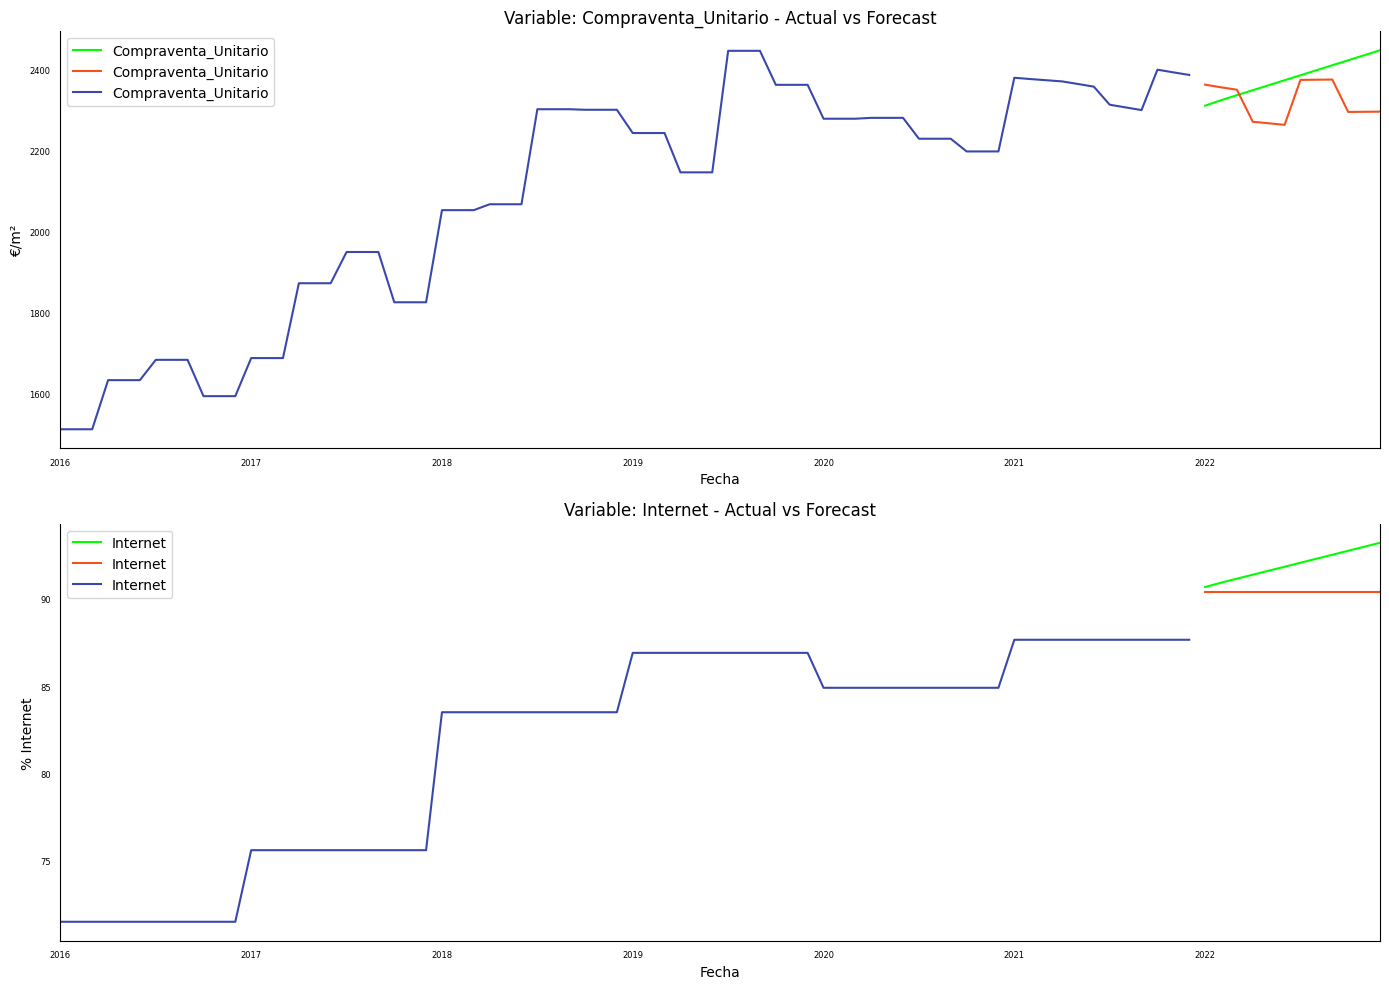

In [68]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Internet']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    res[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo

In [69]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [70]:
for i in ['Compraventa_Unitario','Internet']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , res[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 7611.510387755218
MAE is : 72.24993217700512
RMSE is : 87.2439704951306
MAPE is : 3.143420070755773
R2 is : -2.9705528136949972

Evaluation metric for Internet
Evaluation metric results:-
MSE is : 3.016332795740102
MAE is : 1.545910721933898
RMSE is : 1.7367592797334068
MAPE is : 1.7100782322277635
R2 is : -1.4936156558625131e+28



Estas métricas indican que el modelo para "Compraventa_Unitario" tiene un rendimiento deficiente:

- El valor negativo de R2 sugiere que el modelo no se ajusta bien a los datos.
- El MAPE y el RMSE son relativamente bajos, pero el valor negativo de R2 indica un rendimiento deficiente del modelo en la predicción de "Compraventa_Unitario".

El modelo para "Internet" muestra un rendimiento extremadamente deficiente:

- El valor extremadamente negativo de R2 indica un ajuste muy pobre del modelo a los datos.
- Las métricas de error también son altas, lo que sugiere que el modelo no puede predecir de manera efectiva la variable "Internet".


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, res))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, res)))

Mean absolute error: 40.05939723677432
Root mean squared error: 72.70988360996745


##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de Nou Barris de Barcelona entre las dos series temporales de Compraventa_unitario y Internet, tenemos que:

- Se ha comprobado que las variables tienen alta correlacion.
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad a partir del primer orden de diferenciacion, lo que las hace aptas para aplicar los dos modelos VAR y VARMAX .
- En el modelo VAR se ha comprobado la causalidad de Granger, y esta ha salido negativa, lo que quiere decir que ninguna serie temporal puede causar las demas series temporales. Esto en un principio nos advierte que este modelo sera más aconsejable que el modelo VARMAX
- El test de cointegracion en el modelo VARMAX nos ha dado positivo, lo que significa que las series estan relacionadas en el tiempo y que serie estos datos pueden ser aptos para este modelo

Como hemos visto, los modelos obtenidos no se ajustan a los datos de test, dado que las series temporales no cumplen varias limitaciones de los modelos a aplicar. Fruto de ellos son modelos con limitaciones en la capacidad predictiva, y modelado incorrecto de la relacion entre ellas.

